In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import scipy as scipy
from scipy import optimize
from scipy.optimize import differential_evolution

In [2]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
#line = "S I"
#target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
#df = df[target_mask]
df_wavelength = df['Wavelength']
df_species = df['Species']
wl = evt_data['WAVELENGTH'].data
flux = evt_data['FLUX'].data

In [3]:
def gaussian(x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

In [30]:
def single_gaussian(x, A, mu, sig):
    return triple_gaussian(x, A, mu, sig, 0, 0, 1, 0, 0, 1)

In [31]:
def triple_gaussian(x, A, mu, sig, A2, mu2, sig2, A3, mu3, sig3):
    return (gaussian(x, A, mu, sig) + gaussian(x, A2, mu2, sig2) + gaussian(x, A3, mu3, sig3))

In [32]:
def double_gaussian(x, A, mu, sig, A2, mu2, sig2):
    return triple_gaussian(x, A, mu, sig, A2, mu2, sig2, 0, 0, 1) #change 0 to 1 for orig

This code is to look at specific sections of the spectra.

In [33]:
line = 1389.154
left_bound = 0.999*line
right_bound = 1.001*line
sub_region = (evt_data['WAVELENGTH'] > left_bound) & (evt_data['WAVELENGTH'] < right_bound) #only take values within this area
wl = evt_data['WAVELENGTH'][sub_region]
flux = evt_data['FLUX'][sub_region]
unc = 0.1*flux #placeholder uncertainty
wl = wl.data
flux = flux.data/10**-13

In [34]:
errfunc3 = lambda p, x, y: (triple_gaussian(x, *p) - y)**2
errfunc2 = lambda p, x, y: (double_gaussian(x, *p) - y)**2
errfunc1 = lambda p, x, y: (gaussian(x, *p) - y)**2
guess3 = [0.5, line, 0.01, 0.6, line+1, 0.01, 1, line-1, 0.01]  # I guess there are 3 peaks, 2 are clear, but between them there seems to be another one, based on the change in slope smoothness there
guess2 = [0.5, line, 0.01, 1, line+1, 0.01]  # I removed the peak I'm not too sure about
guess1 = [0.5, line, 0.01]

In [35]:
optim3, success = optimize.leastsq(errfunc3, guess3[:], args=(wl, flux))
optim2, success = optimize.leastsq(errfunc2, guess2[:], args=(wl, flux))
optim1, success = optimize.leastsq(errfunc1, guess1[:], args=(wl, flux))

In [36]:
optim3

array([-1.33103934e-01,  1.39015198e+03,  1.09662924e+00,  1.41974206e-01,
        1.39000673e+03,  9.85175284e-01,  3.38075349e-02,  1.38838472e+03,
        2.50042439e-01])

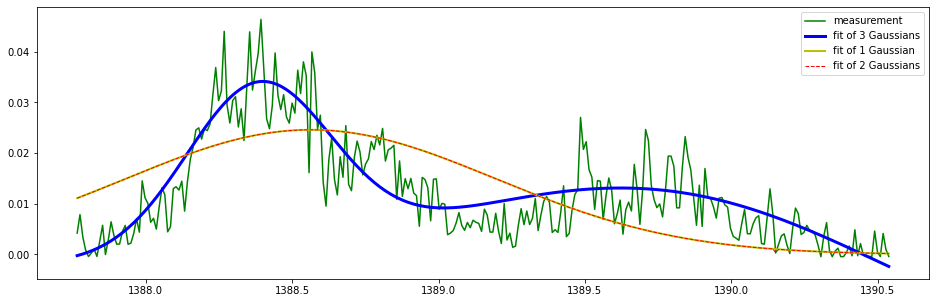

In [37]:
plt.figure(figsize=(16, 5))
plt.plot(wl, flux, c='g', label='measurement')
plt.plot(wl, triple_gaussian(wl, *optim3),
    lw=3, c='b', label='fit of 3 Gaussians')
plt.plot(wl, single_gaussian(wl, *optim1),
    lw=2, c='y', label='fit of 1 Gaussian')
plt.plot(wl, double_gaussian(wl, *optim2),
    lw=1, c='r', ls='--', label='fit of 2 Gaussians')
plt.legend(loc='best')

Now let's try doing this for the whole spectra and giving it an array of the 90+ features.

In [38]:
wl = evt_data['WAVELENGTH'].T
flux = evt_data['FLUX'].T
unc = 0.1*flux #placeholder uncertainty
wl = wl.data
flux = flux.data/10**-13

In [ ]:
errfunc3 = lambda p, x, y: (triple_gaussian(x, *p) - y)**2
errfunc2 = lambda p, x, y: (double_gaussian(x, *p) - y)**2
guess3 = [0.5, line, 0.01, 0.6, line+1, 0.01, 1, line-1, 0.01]  # I guess there are 3 peaks, 2 are clear, but between them there seems to be another one, based on the change in slope smoothness there
guess2 = [0.5, line, 0.01, 1, line+1, 0.01]  # I removed the peak I'm not too sure about

In [ ]:
optim3, success = optimize.leastsq(errfunc3, guess3[:], args=(wl, flux))
optim2, success = optimize.leastsq(errfunc2, guess2[:], args=(wl, flux))